### Guardo los archivos para los subhalos en todos los snapshots

En bash
$mkdir snap_{000..127} ---> Crea las carpetas

In [9]:
import gc
import h5py
import numpy as np

dir_path = '/store/clues/HESTIA/RE_SIMS/8192/GAL_FOR/17_11/output_2x2.5Mpc/snapdir_'
path = '/store/clues/HESTIA/RE_SIMS/8192/GAL_FOR/17_11/AHF_output_2x2.5Mpc/'

f = open('../_simulations2/snapshot_output.txt','w')

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

l = 0
for i in range(127,0,-1):
    
    print('snapshot '+ str('%03d'%i), l)
    f.write('snapshot '+ str('%03d'%i) + '\n')

    StrPos  = []
    StrMass = []
    StrVel  = []
    StrID   = []
    StrMet  = []
    StrTMet = []
    StrBDen = []
    StrBPos = []
    StrBVel = []
    StrSFT  = []
    StrPot  = []

    GasPos  = []
    GasMass = []
    GasVel  = []
    GasID   = []
    GasMet  = []
    GasTMet = []
    GasPot  = []

    DrkPos  = []
    DrkMass = []
    DrkVel  = []
    DrkID   = []
    DrkPot  = []


    for j in range(0,8):
        snap = h5py.File(dir_path + str('%03d'%i) + '/snapshot_'+ str('%03d'%i)+'.'+ str('%s'%j) +'.hdf5','r')
        
        if 'PartType4' in snap:
        #stars
            pos_str    = snap['PartType4/Coordinates'][()]
            mass_str   = snap['PartType4/Masses'][()]
            vel_str    = snap['PartType4/Velocities'][()]
            ID_str     = snap['PartType4/ParticleIDs'][()]
            metal_str  = snap['PartType4/GFM_Metals'][()]
            totmet_str = snap['PartType4/GFM_Metallicity'][()]
            bden_str   = snap['PartType4/BirthDensity'][()]
            bpos_str   = snap['PartType4/BirthPos'][()]
            bvel_str   = snap['PartType4/BirthVel'][()]
            bSFT_str   = snap['PartType4/GFM_StellarFormationTime'][()]
            pot_str    = snap['PartType4/Potential'][()]

            StrPos.append(pos_str)
            StrMass.append(mass_str)
            StrVel.append(vel_str)
            StrID.append(ID_str)
            StrMet.append(metal_str)
            StrTMet.append(totmet_str)
            StrBDen.append(bden_str)
            StrBPos.append(bpos_str)
            StrBVel.append(bvel_str)
            StrSFT.append(bSFT_str)
            StrPot.append(pot_str)

        #gas
        pos_gas    = snap['PartType0/Coordinates'][()]
        mass_gas   = snap['PartType0/Masses'][()]
        vel_gas    = snap['PartType0/Velocities'][()]
        ID_gas     = snap['PartType0/ParticleIDs'][()]
        metal_gas  = snap['PartType0/GFM_Metals'][()]
        totmet_gas = snap['PartType0/GFM_Metallicity'][()]
        pot_gas    = snap['PartType0/Potential'][()]

        GasPos.append(pos_gas)
        GasMass.append(mass_gas)
        GasVel.append(vel_gas)
        GasID.append(ID_gas)
        GasMet.append(metal_gas)
        GasTMet.append(totmet_gas)
        GasPot.append(pot_gas)

        #dark matter
        pos_drk    = snap['PartType1/Coordinates'][()]
        mass_drk   = snap['PartType1/Masses'][()]
        vel_drk    = snap['PartType1/Velocities'][()]
        ID_drk     = snap['PartType1/ParticleIDs'][()]
        pot_drk    = snap['PartType1/Potential'][()]

        DrkPos.append(pos_drk)
        DrkMass.append(mass_drk)
        DrkVel.append(vel_drk)
        DrkID.append(ID_drk)
        DrkPot.append(pot_drk)

    a = snap.get('Header').attrs['Time']
    h = snap.get('Header').attrs['HubbleParam']

    Omega0   = snap.get('Header').attrs['Omega0']
    Omegab   = snap.get('Header').attrs['OmegaBaryon']
    OmegaL   = snap.get('Header').attrs['OmegaLambda']
    Redshift = snap.get('Header').attrs['Redshift']

    Unit_Length = snap.get('Header').attrs['UnitLength_in_cm']
    Unit_Mass   = snap.get('Header').attrs['UnitMass_in_g']
    Unit_Veloc  = snap.get('Header').attrs['UnitVelocity_in_cm_per_s']

    if len(StrPos) != 0:
        StrPos  = np.concatenate(StrPos)
        StrMass = np.concatenate(StrMass)
        StrVel  = np.concatenate(StrVel)
        StrID   = np.concatenate(StrID)
        StrMet  = np.concatenate(StrMet)
        StrTMet = np.concatenate(StrTMet)
        StrBDen = np.concatenate(StrBDen)
        StrBPos = np.concatenate(StrBPos)
        StrBVel = np.concatenate(StrBVel)
        StrSFT  = np.concatenate(StrSFT)
        StrPot  = np.concatenate(StrPot)

    GasPos  = np.concatenate(GasPos)
    GasMass = np.concatenate(GasMass)
    GasVel  = np.concatenate(GasVel)
    GasID   = np.concatenate(GasID)
    GasMet  = np.concatenate(GasMet)
    GasTMet = np.concatenate(GasTMet)
    GasPot  = np.concatenate(GasPot)

    DrkPos  = np.concatenate(DrkPos)
    DrkMass = np.concatenate(DrkMass)
    DrkVel  = np.concatenate(DrkVel)
    DrkID   = np.concatenate(DrkID)
    DrkPot  = np.concatenate(DrkPot)
    

    for k in range(18):
        
        data = np.loadtxt(path + 'HESTIA_100Mpc_8192_17_11.127_halo_'+ str('%d'%ID[k])+'.dat')
        
        print('subhalo='+str('%d'%ID[k]))
        f.write('subhalo='+str('%d'%ID[k]) + '\n')
        
        MVir = data[l,4]
        Xc   = data[l,6]
        Yc   = data[l,7]
        Zc   = data[l,8]
        RVir = data[l,12]
        fMhires = data[l,38]

        HPos = np.array([Xc, Yc, Zc])
        
        if fMhires < 0.9999:
            print('OJO CON LAS PARTICULAS LOW-RES!!! --> fMhires = ' + str('%2.8f'%fMhires))
            f.write('OJO CON LAS PARTICULAS LOW-RES!!! --> fMhires = ' + str('%2.8f'%fMhires) + '\n')
        
        if len(StrPos) != 0:
            SPos = StrPos*1000 - HPos
            xstr = SPos[:,0] * a/h
            ystr = SPos[:,1] * a/h
            zstr = SPos[:,2] * a/h
            rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)
            kstr, = np.where(rstr < 2*RVir*a/h)
        
        GPos = GasPos*1000 - HPos
        xgas = GPos[:,0] * a/h
        ygas = GPos[:,1] * a/h
        zgas = GPos[:,2] * a/h
        rgas = np.sqrt(xgas**2 + ygas**2 + zgas**2)
        kgas,= np.where(rgas < 2*RVir*a/h)

        DPos = DrkPos*1000 - HPos
        xdrk = DPos[:,0] * a/h
        ydrk = DPos[:,1] * a/h
        zdrk = DPos[:,2] * a/h
        rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
        kdrk,= np.where(rdrk < 2*RVir*a/h)


        output_file = h5py.File('../_simulations2/snap_'+ str('%03d'%i) +'/subhalo_'+ str('%d'%ID[k]) +'.h5py', 'a')

        output_file.create_dataset('/Time',          data = a)
        output_file.create_dataset('/h',             data = h)
        output_file.create_dataset('/Omega_0',       data = Omega0)
        output_file.create_dataset('/Omega_Baryon',  data = Omegab)
        output_file.create_dataset('/Omega_Lambda',  data = OmegaL)
        output_file.create_dataset('/Redshift',      data = Redshift)
        output_file.create_dataset('/Center',        data = HPos)
        output_file.create_dataset('/M200'       ,   data = MVir)
        output_file.create_dataset('/R200'       ,   data = RVir)

        if len(StrPos) != 0:
            output_file.create_dataset('/Str/Coordinates',      data = SPos[kstr,:],   dtype=np.float32)
            output_file.create_dataset('/Str/Masses',           data = StrMass[kstr],  dtype=np.float32)
            output_file.create_dataset('/Str/Velocities',       data = StrVel[kstr,:], dtype=np.float32)
            output_file.create_dataset('/Str/IDs',              data = StrID[kstr])
            output_file.create_dataset('/Str/Metallicity',      data = StrMet[kstr],   dtype=np.float32)
            output_file.create_dataset('/Str/Total_Metallicity',data = StrTMet[kstr],  dtype=np.float32)
            output_file.create_dataset('/Str/Birth_Density',    data = StrBDen[kstr],  dtype=np.float32)
            output_file.create_dataset('/Str/Birth_Position',   data = StrBPos[kstr],  dtype=np.float32)
            output_file.create_dataset('/Str/Birth_Velocities', data = StrBVel[kstr],  dtype=np.float32)
            output_file.create_dataset('/Str/FormationTime',    data = StrSFT[kstr],   dtype=np.float32)
            output_file.create_dataset('/Str/Potential',        data = StrPot[kstr],   dtype=np.float32)


        output_file.create_dataset('/Gas/Coordinates',      data = GPos[kgas,:],   dtype=np.float32)
        output_file.create_dataset('/Gas/Masses',           data = GasMass[kgas],  dtype=np.float32)
        output_file.create_dataset('/Gas/Velocities',       data = GasVel[kgas,:], dtype=np.float32)
        output_file.create_dataset('/Gas/IDs',              data = GasID[kgas])
        output_file.create_dataset('/Gas/Metallicity',      data = GasMet[kgas],   dtype=np.float32)
        output_file.create_dataset('/Gas/Total_Metallicity',data = GasTMet[kgas],  dtype=np.float32)
        output_file.create_dataset('/Gas/Potential',        data = GasPot[kgas],   dtype=np.float32)


        output_file.create_dataset('/Drk/Coordinates',      data = DPos[kdrk,:],   dtype=np.float32)
        output_file.create_dataset('/Drk/Masses',           data = DrkMass[kdrk],  dtype=np.float32)
        output_file.create_dataset('/Drk/Velocities',       data = DrkVel[kdrk,:], dtype=np.float32)
        output_file.create_dataset('/Drk/IDs',              data = DrkID[kdrk])
        output_file.create_dataset('/Drk/Potential',        data = DrkPot[kdrk],   dtype=np.float32)


        output_file.close()
        
    l += 1
    f.write('---------------------------------' + '\n')
f.close()

snapshot 127 0
subhalo=127000000000002
subhalo=127000000000003
subhalo=127000000000004
subhalo=127000000000006
subhalo=127000000000007
subhalo=127000000000009
subhalo=127000000000012
subhalo=127000000000011
subhalo=127000000000014
subhalo=127000000000020
subhalo=127000000000021
subhalo=127000000000023
subhalo=127000000000028
subhalo=127000000000031
subhalo=127000000000030
subhalo=127000000000034
subhalo=127000000000036
subhalo=127000000000033
snapshot 126 1


KeyboardInterrupt: 

### Grafico para ver como quedaron los snapshots guardados

subhalo_127000000000002


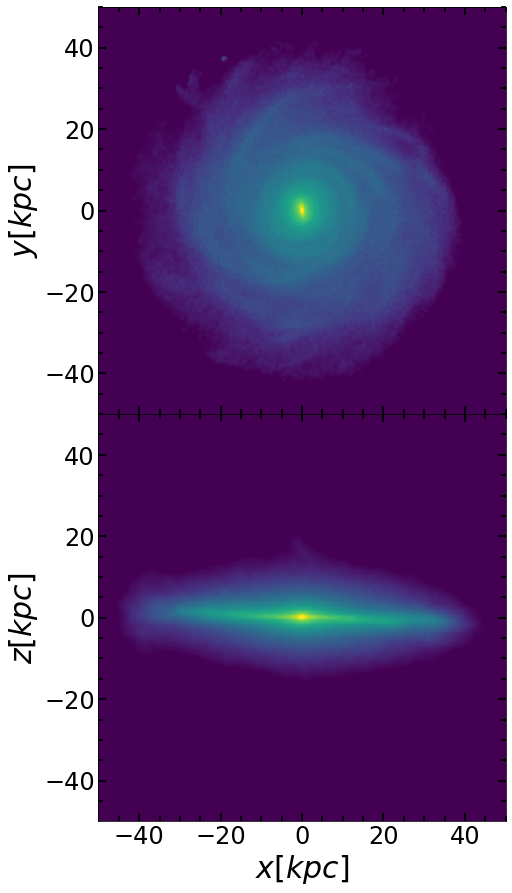

subhalo_127000000000003


<Figure size 432x288 with 0 Axes>

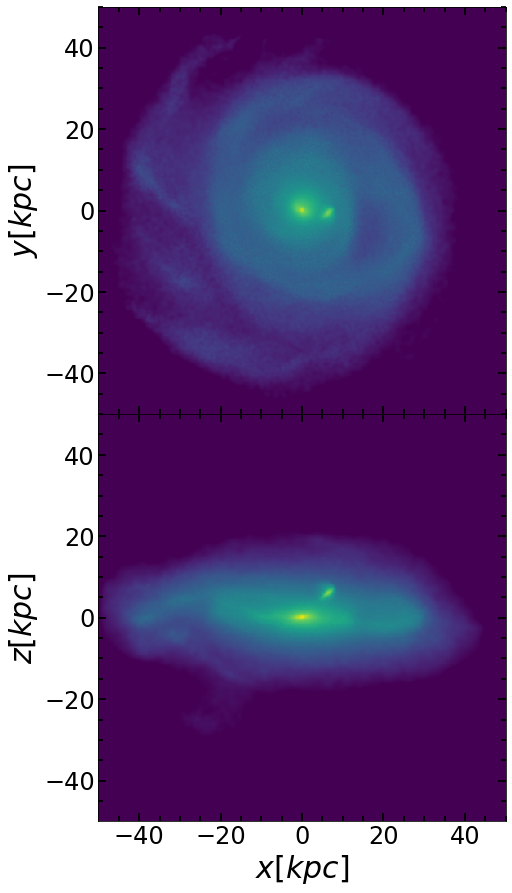

<Figure size 432x288 with 0 Axes>

In [13]:
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import matplotlib.pyplot as plt

# vector = (0,1,3)

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '../_simulations/snap_120/'

for i in range(0,2):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')
    
    print('subhalo_'+str('%d'%ID[i]))
    
    cm   = snap['/Center'][()]
    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Rvir = snap['/R200'][()]
    Mvir = snap['/M200'][()]

    pstr  = snap['/Str/Coordinates'][()]
    m_str = snap['/Str/Masses'][()]
    
    vel  = snap['/Str/Velocities'][()]

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0])*aexp/h
    ystr = (pstr[:,1])*aexp/h
    zstr = (pstr[:,2])*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp)
    v_y = vel[:,1] *np.sqrt(aexp)
    v_z = vel[:,2] *np.sqrt(aexp)

#----------------------masas----------------------------
    mstr = m_str*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    pos=np.ndarray([np.size(xn),3])
    pos[:,0]=xn
    pos[:,1]=yn
    pos[:,2]=zn

#---------------------generador del gráfico-----------------
    rl=50   
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=6.3
    vmax=9.8

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='viridis'

#-----grafico-----------
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 13))
    fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0.03, hspace= 0)

    particles=sph.Particles(pos[corte,:],mstr[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend1=sph.Render(escena)
    extent=escena.get_extent()
    rend1.set_logscale()

    ax[0].imshow(rend1.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
    ax[0].set_xticklabels([])
    #plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    ax[0].set_ylabel('$y[kpc]$', fontsize=30)
    ax[0].minorticks_on()
    ax[0].tick_params( labelsize=24)
    ax[0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
    ax[0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

    particles=sph.Particles(pos[corte,:],mstr[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    ax[1].set_xlabel('$x[kpc]$', fontsize=30)
    ax[1].set_ylabel('$z[kpc]$', fontsize=30)
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=24)
    ax[1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
    ax[1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
    #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
    
    plt.show()
    plt.clf()